In [1]:
from __future__ import print_function, division
import os

from IPython import display
import sys
import importlib
import time
from tqdm import tqdm


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

rcParams.update({'figure.autolayout': True})
#plt.rc('font', family='serif')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

/tmp/ipykernel_122/1828583229.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


In [2]:
import fermipy
from fermipy.utils import make_psf_kernel
import fermipy.irfs as irfs
import pyIrfLoader

In [3]:
E_min = 1e2 #min gamma-ray energy (MeV)
E_max = 1e9 #max gamma-ray energy (MeV)
E_factor = 1.77828 # gamma-ray energy factor


print('Energy, [MeV]')
E = E_min
Energy_list = []

while E <= E_max:
    Energy_list.append(E)
    E *= E_factor
Energy_list.append(E)
    
print(Energy_list)

Energy, [MeV]
[100.0, 177.828, 316.22797584, 562.3418848767552, 1000.0013270386363, 1778.2823598462662, 3162.2839548674183, 5623.426311261633, 10000.026540790337, 17782.84719695664, 31622.88151340406, 56234.33773765618, 100000.39811211923, 177828.7079548194, 316229.2347818963, 562344.1236279506, 1000005.3081651119, 1778289.4394038552, 3162296.544303088, 5623448.698803295, 10000066.352107925, 17782917.99262648, 31623007.40792782, 56234561.61336988, 100000796.2258234, 177829415.91245726, 316230493.7288045, 562346362.3880585, 1000009289.3074368]


In [4]:
Energy_bin = 0 # 100 MeV

map1 = hp.read_map('../GALPROP/SA0/ics_anisotropic_healpix_57_SA0_R12.fits', Energy_bin) # Flux in [MeV^2 cm^−2 sr^−1 s^−1 MeV^−1]
map2 = hp.read_map('../GALPROP/SA0/ics_isotropic_healpix_57_SA0_R12.fits', Energy_bin)
map3 = hp.read_map('../GALPROP/SA0/pi0_decay_healpix_57_SA0_R12.fits', Energy_bin)
map4 = hp.read_map('../GALPROP/SA0/synchrotron_healpix_57_SA0_R12.fits', Energy_bin)
map5 = hp.read_map('../GALPROP/SA0/bremss_healpix_57_SA0_R12.fits', Energy_bin)
result_map = map1 + map2 + map3 + map4 + map5

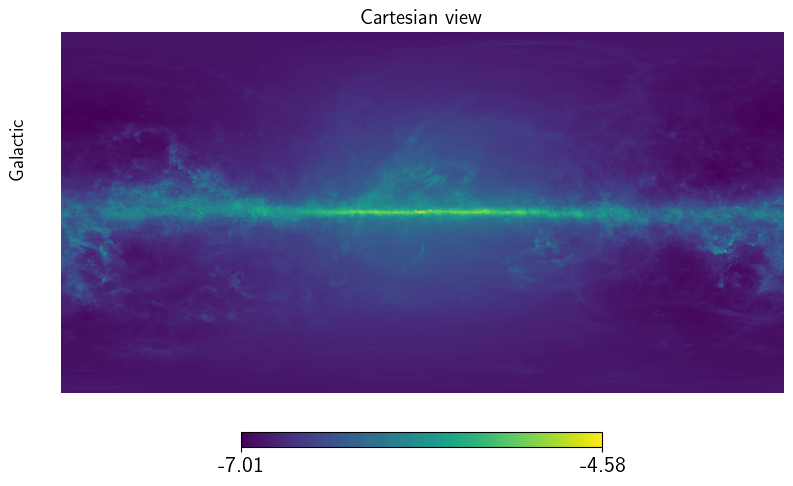

In [5]:
hp.cartview(np.log10(result_map), coord = 'G')

In [6]:
background_maps = np.zeros( (len(Energy_list), len(result_map)) )
for i in range(len(Energy_list)):
    map1 = hp.read_map('../GALPROP/SA0/ics_anisotropic_healpix_57_SA0_R12.fits', i) # Flux in [MeV^2 cm^−2 sr^−1 s^−1 MeV^−1]
    map2 = hp.read_map('../GALPROP/SA0/ics_isotropic_healpix_57_SA0_R12.fits', i)
    map3 = hp.read_map('../GALPROP/SA0/pi0_decay_healpix_57_SA0_R12.fits', i)
    map4 = hp.read_map('../GALPROP/SA0/synchrotron_healpix_57_SA0_R12.fits', i)
    map5 = hp.read_map('../GALPROP/SA0/bremss_healpix_57_SA0_R12.fits', i)
    background_maps[i] = map1+map2+map3+map4+map5

In [7]:
background_maps.max()

2.6075378292528233e-05

In [45]:
#NEED EXPOSURE MAP
#for example purposes, will use a simple overall scaling in order to create mock maps
#NEED TO RETURN TO THIS FOR ACTUAL ANALYSIS

exposure = 3e6

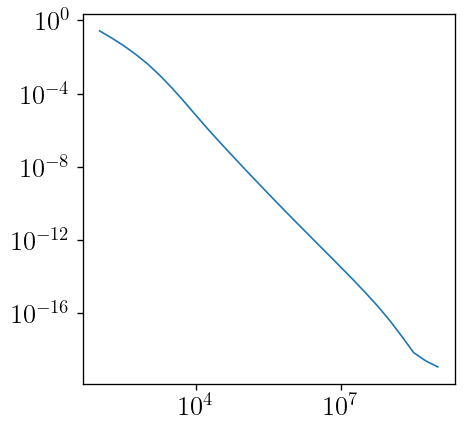

In [46]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi= 120)
ax.plot(Energy_list,background_maps.sum(axis=1),lw=1)
ax.set_xscale('log')
ax.set_yscale('log')

In [47]:
#theta and phi locations of each cell
theta_list,phi_list = hp.pix2ang(256, range(hp.nside2npix(256)))

In [48]:
#approximate angular size of the healpix cells (radians)
res = np.sqrt(4*np.pi/12/256/256)
print(res)

0.003997369952915971


In [49]:
#create random number of gamma rays in each cell

In [50]:
random_map = np.random.poisson(background_maps*exposure)

In [51]:
#iterate through healpy cells, convert counts in healpy cells to individual events

theta_events = np.array([])
phi_events = np.array([])

for i in range(len(random_map[0])):
    counts = random_map[0,i]
    theta = theta_list[i]
    phi = phi_list[i]
#    if i < 10:
#        print(counts,theta,phi)
    
    res = np.sqrt(4*np.pi/12/512/512)
    
    #generate 'counts' random numbers centered on theta,phi, smeared by a gaussian
    if counts==0:
        continue
    else:
        theta_events = np.concatenate([theta_events,theta+np.random.normal(size=int(counts),scale=res)])
        phi_events = np.concatenate([phi_events,phi+np.random.normal(size=int(counts),scale=res)])

In [52]:
phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi
#correctly orient in Galactic coords
phi_events = -phi_events
theta_events = np.pi-theta_events

In [53]:
events = np.stack([phi_events.T,theta_events.T]).T

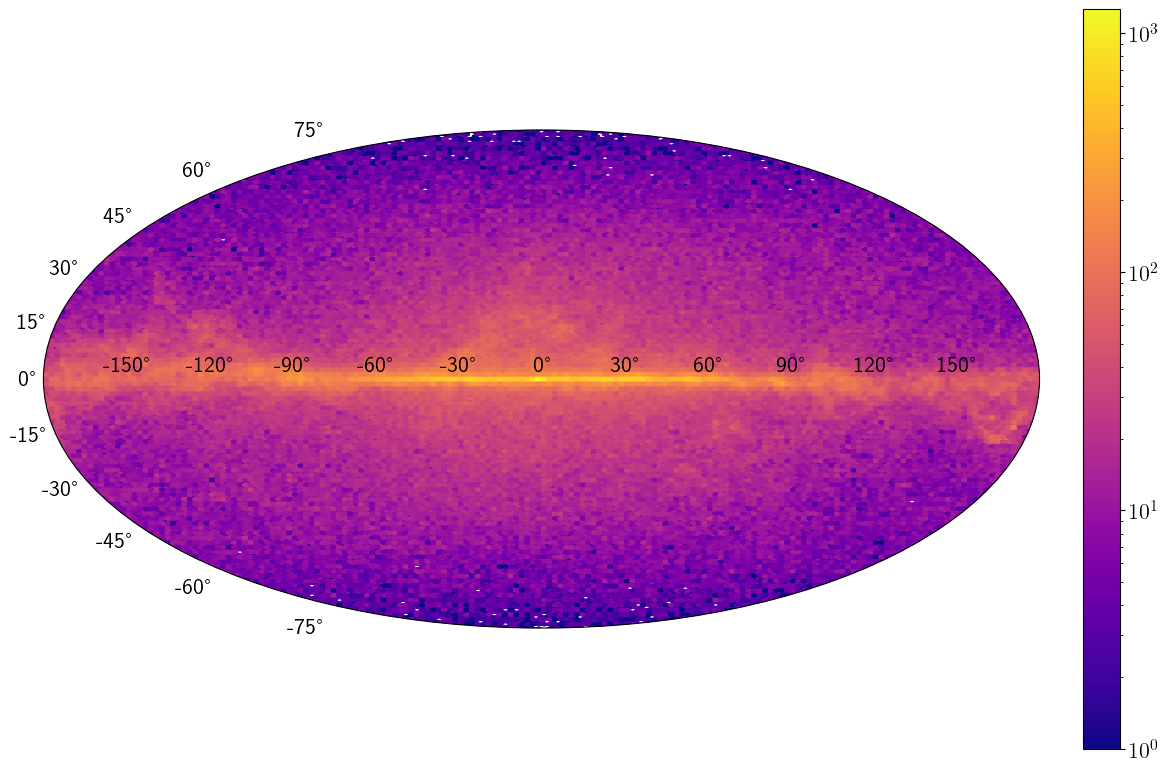

In [54]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

s = ax.hexbin(phi_events,theta_events-np.pi/2,gridsize=200,cmap='plasma',mincnt=1,bins='log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()

In [55]:
#use PSF from psf_fitting notebook
popt = np.array([ 6.2652034 , -1.48602662,  0.05294771])

def line(x,a,b1,b2):
    return a+b1*x+b2*x**2

def psf(energy): #energy in MeV
    p = np.exp(line(np.log(energy),popt[0],popt[1],popt[2])) #degrees
    return p*np.pi/180 #radians

In [56]:
theta_events_new = theta_events+np.random.normal(size=len(theta_events),scale=psf(Energy_list[0]))
phi_events_new = phi_events+np.random.normal(size=len(theta_events),scale=psf(Energy_list[0]))

In [57]:
phi_events_new[phi_events_new>np.pi] = phi_events_new[phi_events_new>np.pi]-2*np.pi

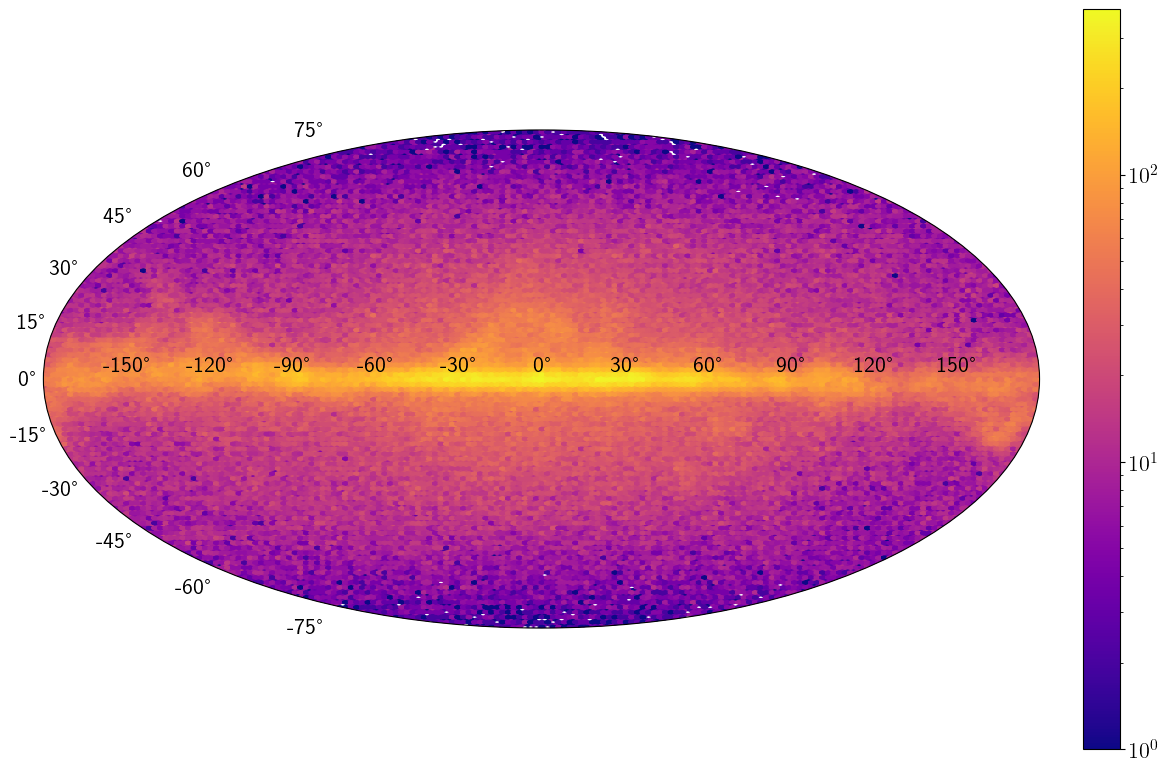

In [58]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

s = ax.hexbin(phi_events_new,theta_events_new-np.pi/2,gridsize=200,cmap='plasma',mincnt=1,bins='log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()

In [59]:
print(len(theta_events_new))

808908


In [118]:
n_theta_high = np.where(theta_events_new - np.pi/2 < 40 * np.pi / 180)[0]
n_theta_low = np.where(theta_events_new - np.pi/2 > 10 * np.pi / 180)[0]
n_theta_sec = np.intersect1d(n_theta_high, n_theta_low)

n_phi_high = np.where(phi_events_new < 5 * np.pi / 180)[0]
n_phi_low = np.where(phi_events_new > -25 * np.pi / 180)[0]
n_phi_sec = np.intersect1d(n_phi_high, n_phi_low)

n_sec = np.intersect1d(n_theta_sec, n_phi_sec)

theta_events_sec = theta_events_new[n_sec]
phi_events_sec = phi_events_new[n_sec]

(array([4046., 3661., 3509., 3232., 2693., 2214., 1854., 1657., 1496.,
        1296.]),
 array([10.00009181, 12.99987401, 15.9996562 , 18.9994384 , 21.9992206 ,
        24.99900279, 27.99878499, 30.99856718, 33.99834938, 36.99813158,
        39.99791377]),
 <BarContainer object of 10 artists>)

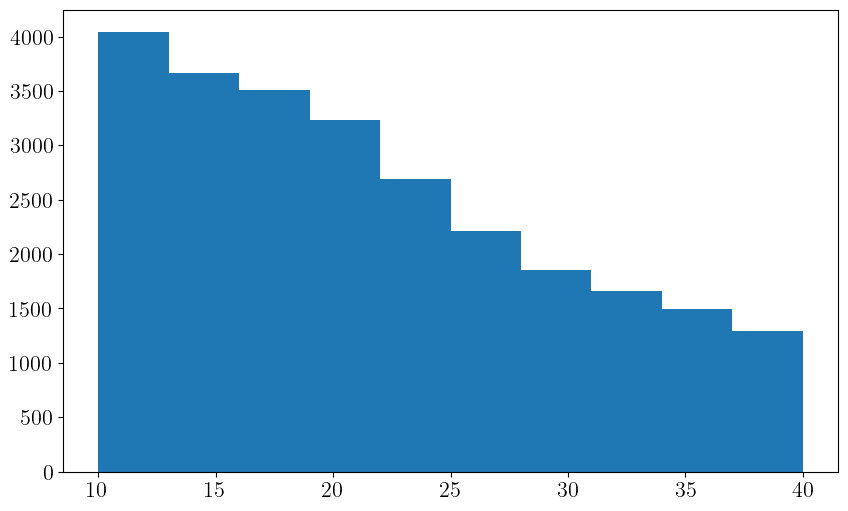

In [119]:
plt.hist(
    (theta_events_new[n_sec] - np.pi/2) * 180 / np.pi)

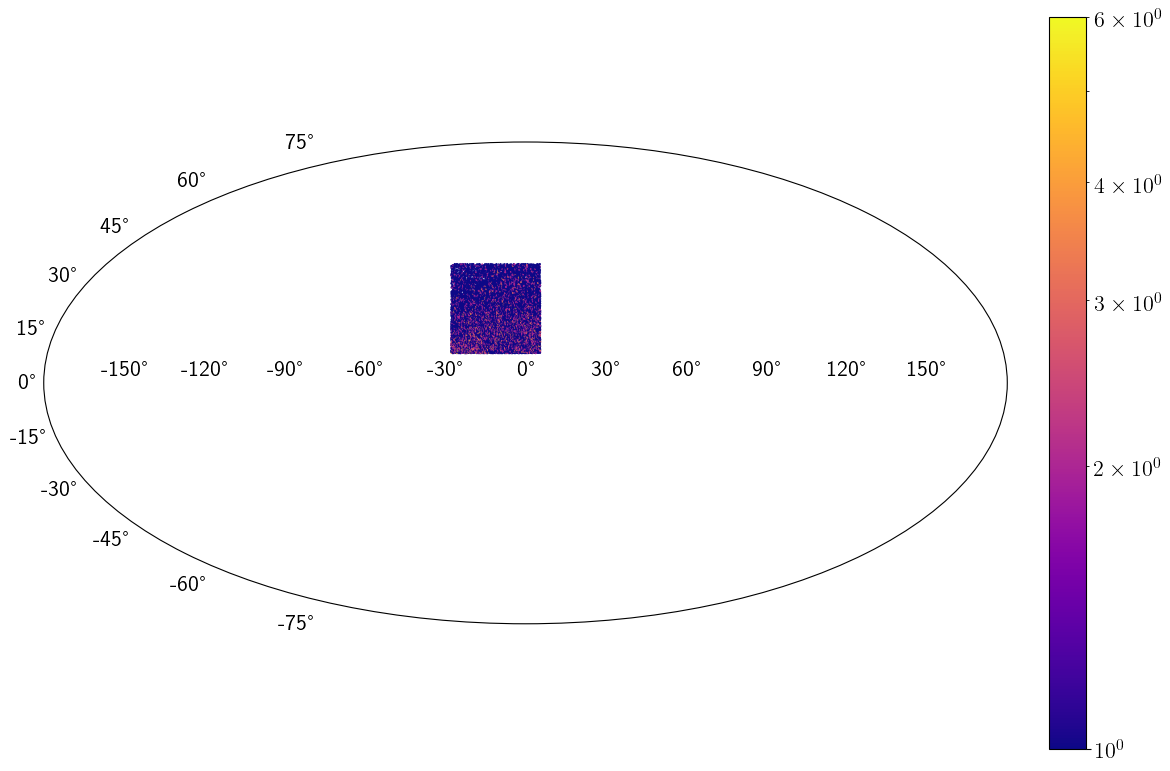

In [120]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

s = ax.hexbin(phi_events_sec,theta_events_sec-np.pi/2,gridsize=200,cmap='plasma',mincnt=1, bins = 'log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()

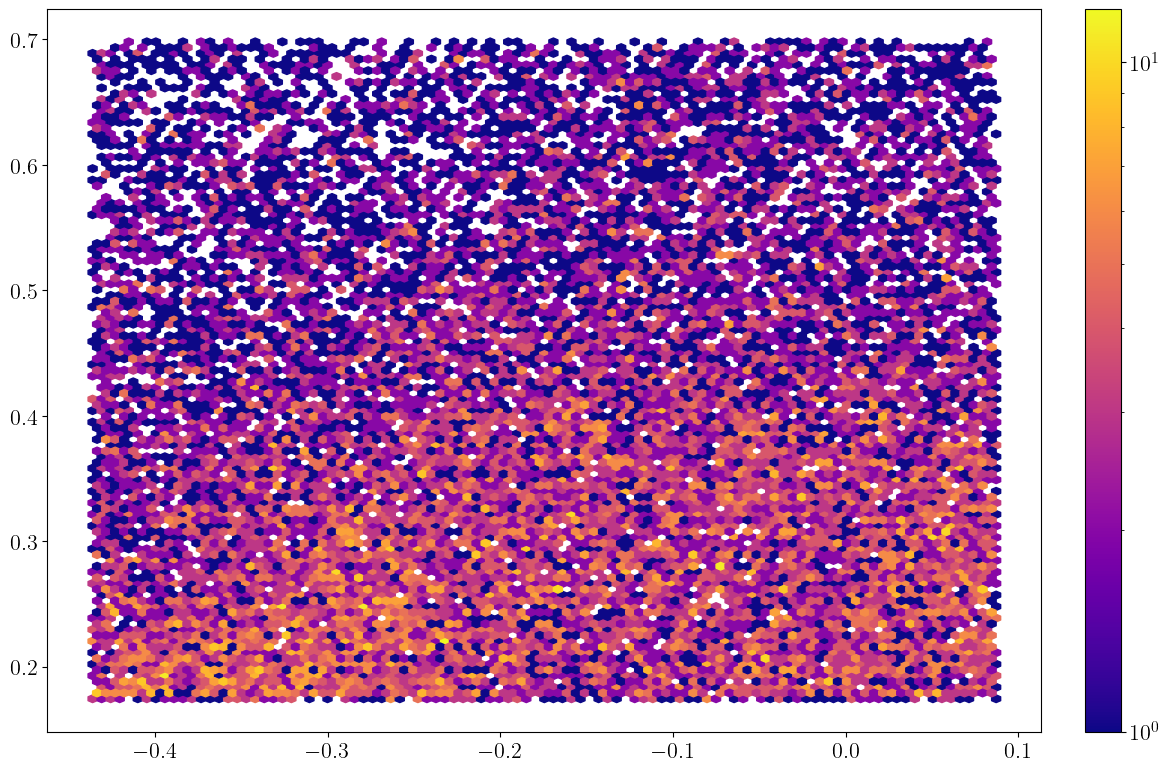

In [121]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111)

s = ax.hexbin(phi_events_sec,theta_events_sec-np.pi/2,gridsize=100,cmap='plasma',mincnt=1,bins='log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()

In [106]:
print(theta_events_sec.shape)

(24305,)


In [123]:
np.save('sample_skymap_upsampled', [phi_events_new, theta_events_new])
np.save('sample_skymap_upper', [phi_events_sec, theta_events_sec])